# ELMo Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import allennlp.commands.elmo
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import sklearn.metrics
import tqdm
import random

import src.corpus

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Parse the corpus

In [2]:
#UD_FILE = "../data/en_ewt-ud-train.conllu"
#corpus = src.corpus.POSCorpus.create_from_ud(data_file_path=UD_FILE)

BNC_FILE = "../data/bnc/bnc.pkl"
corpus = src.corpus.POSCorpus.create_from_bnc_pickled(data_file_path=BNC_FILE)

In [3]:
# Define the two POS (NOUN, VERB, ADJ) to compare for the rest of the analysis
POS1 = 'NOUN'
POS2 = 'VERB'

## Run ELMo on random part of the corpus

In [4]:
# Take only 1M words out of 4M to make it run faster
SAMPLE_PROPORTION = 0.25
random.seed(12345)
random_indices = random.sample(range(len(corpus.sentences)), int(SAMPLE_PROPORTION * len(corpus.sentences)))

sampled_sentences = []
for ix in random_indices:
  sampled_sentences.append(corpus.sentences[ix])

In [5]:
elmo = allennlp.commands.elmo.ElmoEmbedder(cuda_device=0)
data_as_tokens = [[t['word'] for t in sentence] for sentence in sampled_sentences]

BATCH_SIZE = 64
elmo_embeddings = []
for ix in tqdm.tqdm(range(0, len(data_as_tokens), BATCH_SIZE)):
  batch = data_as_tokens[ix : ix+BATCH_SIZE]
  batch_embeddings = elmo.embed_batch(batch)
  # Only take embeddings from last ELMo layer
  batch_embeddings = [x[-1] for x in batch_embeddings]
  elmo_embeddings.extend(batch_embeddings)

100%|██████████| 1082/1082 [03:02<00:00,  5.93it/s]


## ELMo embeddings of instances of a fixed lemma

In [6]:
def get_elmo_embeddings_for_lemma(lemma):
  pos1_embeddings = []
  pos2_embeddings = []

  for sentence_ix in range(len(sampled_sentences)):
    token_list = sampled_sentences[sentence_ix]
    embeddings = elmo_embeddings[sentence_ix]
    for i in range(len(token_list)):
      if token_list[i]['lemma'] == lemma:
        if token_list[i]['pos'] == POS1:
          pos1_embeddings.append(embeddings[i])
        elif token_list[i]['pos'] == POS2:
          pos2_embeddings.append(embeddings[i])

  pos1_embeddings = np.vstack(pos1_embeddings)
  pos2_embeddings = np.vstack(pos2_embeddings)
  return pos1_embeddings, pos2_embeddings

In [7]:
FIXED_LEMMA = "use"
pos1_embeddings, pos2_embeddings = get_elmo_embeddings_for_lemma(FIXED_LEMMA)
print("%s instances: %d" % (POS1, pos1_embeddings.shape[0]))
print("%s instances: %d" % (POS2, pos2_embeddings.shape[0]))

NOUN instances: 195
VERB instances: 704


## Apply PCA and plot

In [8]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([pos1_embeddings, pos2_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = [POS1] * len(pos1_embeddings) + [POS2] * len(pos2_embeddings)

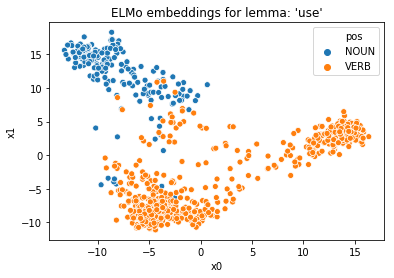

In [9]:
plot = sns.scatterplot(data=all_embeddings_df, x='x0', y='x1', hue='pos')
plot.set(title="ELMo embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()

## Utility to inspect what ELMo is capturing

In [10]:
num_printed = 0
for sentence_ix in range(len(sampled_sentences)):
  token_list = sampled_sentences[sentence_ix]
  embeddings = elmo_embeddings[sentence_ix]
  for i in range(len(token_list)):
    if token_list[i]['lemma'] == FIXED_LEMMA:
      v = pca.transform(embeddings[i][np.newaxis, :])[0]
      if v[1] < -10: # <- Put whatever condition here
        print(v)
        print(' '.join([t['word'] for t in token_list]))
        print()
        num_printed += 1
  if num_printed > 10:
    break

[ -6.6246395 -10.101444 ]
The second problem involving tense relates to whether you should use the present or the past tense in your writing .

[ -5.7130756 -10.548279 ]
Using our discussion of essay types above ( pp. 53 – 7 ) , decide which of the following types your essay is : DESCRIPTIVE If so , how is it organised : line by line ? thematically ? etc .

[ -5.043705  -10.0042095]
They use potassium cyanide commercially .

[ -4.0953245 -10.162424 ]
A particularly severe test is to use the results to estimate the population of the area over the kilometre square grid given by the UK Ordnance Survey .

[ -5.3253455 -10.082949 ]
Excuse me just because the tape 's on there 's no need for you to use big words like prognosis .

[ -5.432356 -10.07671 ]
She herself was going to use her own entrance .

[ -4.9081984 -10.949258 ]
Using the same information available for a sequential description , however , it is possible to organise an essay in more interesting ways .

[ -6.1342735 -10.320608 ]


## Cosine similarity between POS1 and POS2 usages

In [11]:
lemma_count_df = corpus.get_per_lemma_stats()

# Filter: must have at least [x] POS1 and [x] POS2 usages
lemma_count_df = lemma_count_df[(lemma_count_df['pos1_count'] >= 30) & (lemma_count_df['pos2_count'] >= 30)]
lemma_count_df = lemma_count_df.sort_values('total_count', ascending=False)
print('Remaining lemmas:', len(lemma_count_df))

Remaining lemmas: 320


In [12]:
def get_pos_cosine_similarity(row):
  pos1_embeddings, pos2_embeddings = get_elmo_embeddings_for_lemma(row.lemma)
  
  avg_pos1_embedding = np.mean(pos1_embeddings, axis=0)
  avg_pos2_embedding = np.mean(pos2_embeddings, axis=0)

  return float(sklearn.metrics.pairwise.cosine_similarity(avg_pos1_embedding[np.newaxis,:], avg_pos2_embedding[np.newaxis,:]))

lemma_count_df['pos_cosine_similarity'] = lemma_count_df.apply(get_pos_cosine_similarity, axis=1)

In [13]:
lemma_count_df[['lemma', 'pos1_count', 'pos2_count', 'majority_tag', 'pos_cosine_similarity']] \
  .sort_values('pos_cosine_similarity').head(8)

,lemma,pos1_count,pos2_count,majority_tag,pos_cosine_similarity
11669,sue,39,66,VERB,0.202477
859,may,92,2954,VERB,0.228061
11805,pat,107,30,NOUN,0.277801
6955,peer,35,73,VERB,0.294765
550,press,130,188,VERB,0.298041
1258,base,109,378,VERB,0.308212
1216,wave,402,120,NOUN,0.333697
1071,miss,320,410,VERB,0.352287


In [14]:
lemma_count_df[['lemma', 'pos1_count', 'pos2_count', 'majority_tag', 'pos_cosine_similarity']] \
  .sort_values('pos_cosine_similarity', ascending=False).head(8)

,lemma,pos1_count,pos2_count,majority_tag,pos_cosine_similarity
6829,worry,44,338,VERB,0.878884
2008,equal,47,38,NOUN,0.872564
2554,sleep,171,291,VERB,0.869839
335,time,5349,33,NOUN,0.860126
10,matter,572,294,NOUN,0.851477
194,mind,736,620,NOUN,0.843908
724,fear,209,99,NOUN,0.840434
149,go,293,13786,VERB,0.836792


/scratch/gobi1/wgao/anaconda-pkgs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


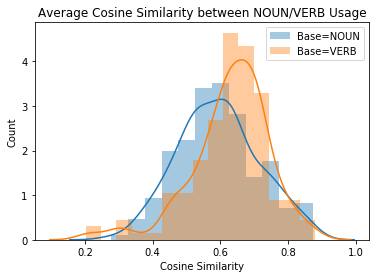

In [15]:
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == POS1].pos_cosine_similarity, label='Base=%s' % POS1)
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == POS2].pos_cosine_similarity, label='Base=%s' % POS2)
plt.legend()
plot.set(title="Average Cosine Similarity between %s/%s Usage" % (POS1, POS2),
         xlabel="Cosine Similarity", ylabel="Count")
plt.show()

In [16]:
# T-test of difference in mean
import scipy.stats
scipy.stats.ttest_ind(lemma_count_df[lemma_count_df.majority_tag == POS1].pos_cosine_similarity,
                      lemma_count_df[lemma_count_df.majority_tag == POS2].pos_cosine_similarity)

Ttest_indResult(statistic=-2.6666293290777436, pvalue=0.0080534737296621)